# Automatic calibration

Parameter estimation (roughness) for  MIKE 21 FM HD model.

For this example a simulation is used as ground truth (observation). The "observation" simulation comprises a roughness map with two zones with 60 and 75 $m^{1/3} s^{-1}$ roughness.
An optimization run is then started with another roughness map 50, 90 $m^{1/3} s^{-1}$.

**Optimization**:

* For optimization three water level points are assessed, meaning simulation and "observation" are compared here.
* Evaluation is conducted via the metrics RMSE and CC (modelskill).
* The mean of all three stations is taken for each metric and optimized.
* objective is to **minimize RMSE** and **maximize CC** 


In [19]:
# import libraries
import os # for changing directory
from pathlib import Path
import numpy as np

import subprocess # for executing mike 
import mikeio
import modelskill as ms
import optuna



# set "static" paths here
femengine_exe = r'C:\Program Files (x86)\DHI\MIKE Zero\2023\bin\x64\femenginehd.exe'


# folders for notebooks, simulations and observations
nb_fold = Path("C:\Source\\autocalibration\notebooks") # required?
sim_fold = Path("C:\Source\\autocalibration\data\Example_Corner")

obs_fold = Path("C:\Source\\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files")

roughness_template = Path("C:\Source\\autocalibration\data\Example_Corner\manning_number.dfsu")


## exploring setup and data

* synthetic observations are generated from run with roughness map with two sections and 60 as well as 75 m1/3 / s

## run model

on 10 core i7 CPU two subdomains and 5 threads per domain are a good choice (running in ~7 sec).

1 subdomain and 12 threads seems to be default when running programatically --> also very fast (~20 s)

<mark>how do i set domains and threads when executing programatically?</mark>

maybe use batch file

In [14]:
simfile_name = 'sim_.m21fm'

# ----------------------------------------------------
# switching folders and running simulation
# ----------------------------------------------------
os.chdir(sim_fold)
subprocess.call([femengine_exe,f'{simfile_name}'])

0

## evaluate model

In [15]:
# ----------------------------------------------------
# reading observations
# ----------------------------------------------------
obs_file = "PointsObs.dfs0" # all observations in one file
# surface elevation 
o1_se = ms.PointObservation(os.path.join(obs_fold,obs_file), 
                            item=0,
                            name='P1 OBS SE')
o2_se = ms.PointObservation(os.path.join(obs_fold,obs_file), 
                            item=1,
                            name='P2 OBS SE')
o3_se = ms.PointObservation(os.path.join(obs_fold,obs_file), 
                            item=2,
                            name='P3 OBS SE')

In [16]:
# ----------------------------------------------------
# reading simulation results
# ----------------------------------------------------
sim_file = "Points.dfs0"

current_sim_fold = os.path.join(sim_fold, simfile_name + " - Result Files")
# surface elevation
mr1_se = ms.ModelResult(os.path.join(current_sim_fold,sim_file), 
                       item=0, 
                       name="P1 MR SE")
mr2_se = ms.ModelResult(os.path.join(current_sim_fold,sim_file),
                       item=1,
                       name="P2 MR SE")
mr3_se = ms.ModelResult(os.path.join(current_sim_fold,sim_file),
                       item=2,
                       name="P3 MR SE")

In [17]:
# adding comparison for each point manually - should be more flexible later
c1 = ms.compare(o1_se, mr1_se)
c2 = ms.compare(o2_se, mr2_se)
c3 = ms.compare(o3_se, mr3_se)
cc = c1 + c2 + c3
cc

<ComparerCollection>
Comparer: P1 OBS SE
Comparer: P2 OBS SE
Comparer: P3 OBS SE

In [18]:
s = cc.skill(metrics=['rmse', 'cc'])
s.round(3)

,,n,rmse,cc
model,observation,,,
Point 1: Surface elevation,P1 OBS SE,721,0.001,0.999
Point 2: Surface elevation,P2 OBS SE,721,0.005,0.995
Point 3: Surface elevation,P3 OBS SE,721,0.002,0.945


<Axes: title={'center': 'cc'}, xlabel='observation'>

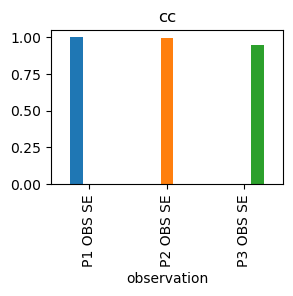

In [79]:
s.plot_bar(field='cc', figsize=(3,2), legend=False)

<Axes: title={'center': 'rmse'}, xlabel='observation'>

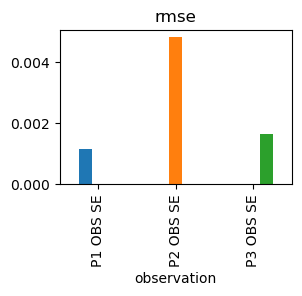

In [78]:
s.plot_bar(field='rmse', figsize=(3,2), legend=False)

## adjust roughness map

use template roughness map to adjust and store under new name.

<mikeio.Dataset>
dims: (time:1, element:778)
time: 2023-09-11 10:51:53 (time-invariant)
geometry: Dfsu2D (778 elements, 443 nodes)
items:
  0:  Manning roughness <Mannings M> (meter pow  1 per 3  per sec)


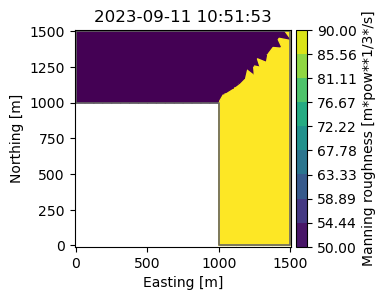

In [3]:
# ----------------------------------------------------
# reading roughness template
# ----------------------------------------------------
dfs_roughness = mikeio.read(roughness_template)
print(dfs_roughness)
dfs_roughness[0].plot(figsize=(3,3));

**versioning filenames of trials**

In [ ]:
# ----------------------------------------------------
# trial versioning (roughness map and simulation setup)
# ----------------------------------------------------
trial_number = 1 # TODO automatically later
versioning = f"trial_{trial_number}"

**identify roughness zones**

In [45]:
# ----------------------------------------------------
# identification of sections and adjusting values
# ----------------------------------------------------
dfs_roughness_new = dfs_roughness.copy()

# get unique values and print number of zones
ori_values = np.unique(dfs_roughness_new[0].values)
print(f"zones: {len(ori_values)}\nvalues: {ori_values} m^1/3 s^-1")

zones: 2
values: [50. 90.] m^1/3 s^-1


**alter roughness zones one-by-one**

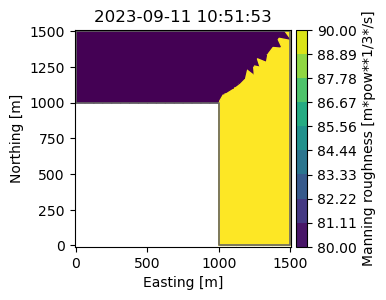

In [11]:
# find indices of values 
# TODO: loop through all unique values later
indx_n = np.where(dfs_roughness_new[0].values == ori_values[0])	
# change values
dfs_roughness_new[0].values[indx_n] = 80
dfs_roughness_new[0].plot(figsize=(3,3));

**write modified roughness map** with version tag

In [64]:
# save adjustment to new file
new_manning_filename = f"manning_number_{versioning}.dfsu"
dfs_roughness_new.to_dfs(os.path.join(roughness_template.parent, new_manning_filename))

## adjust setup (pfs)

In [66]:
# ----------------------------------------------------
# adjust setup file
# ----------------------------------------------------
# read pfs file
pfs = mikeio.read_pfs(os.path.join(sim_fold, simfile_name))
# change roughness file name
old_manning_pfs = pfs.HD.BED_RESISTANCE.MANNING_NUMBER.file_name
new_manning_pfs = old_manning_pfs.replace(roughness_template.name	, new_manning_filename)
pfs.HD.BED_RESISTANCE.MANNING_NUMBER.file_name = new_manning_pfs
# write modified pfs file
new_pfs_filename = simfile_name.split('.')[0] + versioning + "." + simfile_name.split('.')[1]
pfs.write(new_pfs_filename)

'|.\\manning_number_trial_1.dfsu|'

## next evaluation....

------


# All in loop

In [1]:
# import libraries
import os # for changing directory
from pathlib import Path
import numpy as np

import subprocess # for executing mike 
import mikeio
import modelskill as ms
import optuna



# set "static" paths here
femengine_exe = r'C:\Program Files (x86)\DHI\MIKE Zero\2023\bin\x64\femenginehd.exe'

# folders for notebooks, simulations and observations
sim_fold = Path("C:\Source\\autocalibration\data\Example_Corner")
obs_fold = Path("C:\Source\\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files")

roughness_template = Path("C:\Source\\autocalibration\data\Example_Corner\manning_number.dfsu")


In [2]:
# ----------------------------------------------------
# setup optuna study
# ----------------------------------------------------

# calibration study and storage
study_name = 'example_corner'
storage = f"sqlite:///../trial_database/{study_name}.db" # just create database in notebook folder with the same name as study

study = optuna.create_study(
    study_name=study_name, 
    storage=storage,
    # rmse minimized, cc maximized 
    directions=['minimize', 'maximize'], 
    sampler=None, # *If None is specified, TPESampler is used during single-objective optimization and NSGAIISampler during multi-objective optimization
    load_if_exists=False
    ) 
study.set_metric_names(['rmse', 'cc'])	

[I 2023-09-12 08:24:03,104] A new study created in RDB with name: example_corner
C:\Users\clcr\AppData\Local\Temp\ipykernel_13784\3993362658.py:17: ExperimentalWarning: set_metric_names is experimental (supported from v3.2.0). The interface can change in the future.
  study.set_metric_names(['rmse', 'cc'])


In [3]:
# ----------------------------------------------------
# define objective function
# ----------------------------------------------------
def objective(trial):
    
    # ----------------------------------------------------
    # trial versioning (roughness map and simulation setup)
    # ----------------------------------------------------
    TRIAL = trial.number
    versioning = f"trial_{TRIAL}"
    print("Trial Number:", TRIAL) # TODO: remove later
    
    
    # ----------------------------------------------------
    # identification of roughness sections and adjusting map
    # ----------------------------------------------------
    print("reading roughness template", roughness_template) # TODO: remove later
    dfs_roughness = mikeio.read(roughness_template)
    dfs_roughness_new = dfs_roughness.copy()
    # get unique values and print number of zones
    ori_values = np.unique(dfs_roughness_new[0].values)
    print(f"template\nzones: {len(ori_values)}\nvalues: {ori_values} m^1/3 s^-1") # TODO: remove later
    # find indices of values 
    indx_1 = np.where(dfs_roughness_new[0].values == ori_values[0])	
    indx_2 = np.where(dfs_roughness_new[0].values == ori_values[1])	



    # ----------------------------------------------------
    # modify parameters (ADJUST NUMBER TO MATCH ZONES)
    # ----------------------------------------------------
    roughness_1 = trial.suggest_int('roughness_1', low=30, high=150, step=10, log=False)
    roughness_2 = trial.suggest_int('roughness_2', low=30, high=150, step=10, log=False)
    print(f"modified\nzones: 2\nvalues: [{roughness_1}, {roughness_2}] m^1/3 s^-1")

    # change values
    dfs_roughness_new[0].values[indx_1] = roughness_1
    dfs_roughness_new[0].values[indx_2] = roughness_2
    # plot new roughness map
    dfs_roughness_new[0].plot(figsize=(3,3));
    # save adjustment to new file
    new_manning_filename = f"manning_number_{versioning}.dfsu"
    dfs_roughness_out = os.path.join(roughness_template.parent, new_manning_filename)
    print("saving roughness map", dfs_roughness_out) # TODO: remove later
    dfs_roughness_new.to_dfs(dfs_roughness_out)   
    
    
    # ----------------------------------------------------
    # adjust setup file
    # ----------------------------------------------------
    # read pfs file
    simfile_name = 'sim_.m21fm'
    pfs_in = os.path.join(sim_fold, simfile_name)
    print("reading simulation setup template", pfs_in) # TODO: remove later
    pfs = mikeio.read_pfs(pfs_in)
    # change roughness file name
    old_manning_pfs = pfs.HD.BED_RESISTANCE.MANNING_NUMBER.file_name
    new_manning_pfs = old_manning_pfs.replace(roughness_template.name, new_manning_filename)
    pfs.HD.BED_RESISTANCE.MANNING_NUMBER.file_name = new_manning_pfs
    print("replace roughness map in simulation setup with new", new_manning_pfs) # TODO: remove later
    # write modified pfs file
    new_pfs_filename = simfile_name.split('.')[0] + versioning + "." + simfile_name.split('.')[1]
    pfs_out = os.path.join(sim_fold, new_pfs_filename) 
    print("saving new simulation setup", pfs_out) # TODO: remove later
    pfs.write(pfs_out)   
    
    
    
    # ----------------------------------------------------
    # switching folders and running simulation
    # ----------------------------------------------------
    os.chdir(sim_fold)
    print("switching to simulation folder", sim_fold) # TODO: remove later
    subprocess.call([femengine_exe,f'{new_pfs_filename}'])
    
    
    
    # ----------------------------------------------------
    # evaluate skill
    # ----------------------------------------------------
    # reading observations
    obs_file = "PointsObs.dfs0" # all observations in one file
    # surface elevation 
    print("reading first observation: ", os.path.join(obs_fold,obs_file))
    o1_se = ms.PointObservation(os.path.join(obs_fold,obs_file), 
                                item=0,
                                name='P1 OBS SE')
    o2_se = ms.PointObservation(os.path.join(obs_fold,obs_file), 
                                item=1,
                                name='P2 OBS SE')
    o3_se = ms.PointObservation(os.path.join(obs_fold,obs_file), 
                                item=2,
                                name='P3 OBS SE')
    # reading simulation results
    sim_file = "Points.dfs0"

    current_sim_fold = os.path.join(sim_fold, new_pfs_filename + " - Result Files")
    # surface elevation
    print("reading first model result: ", os.path.join(current_sim_fold,sim_file))
    mr1_se = ms.ModelResult(os.path.join(current_sim_fold,sim_file), 
                        item=0, 
                        name="P1 MR SE")
    mr2_se = ms.ModelResult(os.path.join(current_sim_fold,sim_file),
                        item=1,
                        name="P2 MR SE")
    mr3_se = ms.ModelResult(os.path.join(current_sim_fold,sim_file),
                        item=2,
                        name="P3 MR SE")
    # adding comparison for each point manually - should be more flexible later
    c1 = ms.compare(o1_se, mr1_se)
    c2 = ms.compare(o2_se, mr2_se)
    c3 = ms.compare(o3_se, mr3_se)
    cc = c1 + c2 + c3

    s = cc.skill(metrics=['rmse', 'cc'])
    s.round(3)

    # do plots
    s.plot_bar(field='cc', figsize=(3,2), legend=False)
    s.plot_bar(field='rmse', figsize=(3,2), legend=False)   
    
    print("--------------------------------------------\n")
    # return values are used for optimization (using mean through stations) could use error std. dev as well
    return s["rmse"].mean(), s["cc"].mean()

Trial Number: 0
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [140, 120] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_0.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_0.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_0.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:24:47,139] Trial 0 finished with values: {'rmse': 0.004751371188523114, 'cc': 0.793028248167802} and parameters: {'roughness_1': 140, 'roughness_2': 120}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_0.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 1
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [100, 120] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_1.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_1.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_1.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:25:13,122] Trial 1 finished with values: {'rmse': 0.0038995815922848336, 'cc': 0.8882192092811824} and parameters: {'roughness_1': 100, 'roughness_2': 120}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_1.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 2
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [140, 40] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_2.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_2.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_2.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Example_

[I 2023-09-12 08:25:41,398] Trial 2 finished with values: {'rmse': 0.011198191098526995, 'cc': 0.6738858992434041} and parameters: {'roughness_1': 140, 'roughness_2': 40}. 


--------------------------------------------

Trial Number: 3
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [120, 140] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_3.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_3.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_3.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:26:12,007] Trial 3 finished with values: {'rmse': 0.005513206233864342, 'cc': 0.8222303631789104} and parameters: {'roughness_1': 120, 'roughness_2': 140}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_3.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 4
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [140, 80] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_4.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_4.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_4.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Example_

[I 2023-09-12 08:26:48,679] Trial 4 finished with values: {'rmse': 0.0037541914973551424, 'cc': 0.8114075309023684} and parameters: {'roughness_1': 140, 'roughness_2': 80}. 


--------------------------------------------

Trial Number: 5
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [140, 100] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_5.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_5.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_5.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_5.m21fm - Result Files\Points.dfs0


[I 2023-09-12 08:27:37,556] Trial 5 finished with values: {'rmse': 0.0032389810252479168, 'cc': 0.8027569655951384} and parameters: {'roughness_1': 140, 'roughness_2': 100}. 


--------------------------------------------

Trial Number: 6
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [130, 140] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_6.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_6.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_6.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_6.m21fm - Result Files\Points.dfs0


c:\Users\clcr\AppData\Local\mambaforge\envs\autocalibration\Lib\site-packages\pandas\plotting\_matplotlib\core.py:513: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)
[I 2023-09-12 08:28:22,850] Trial 6 finished with values: {'rmse': 0.00576259666001142, 'cc': 0.8012442049832403} and parameters: {'roughness_1': 130, 'roughness_2': 140}. 


--------------------------------------------

Trial Number: 7
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [50, 50] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_7.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_7.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_7.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_7.m21fm - Result Files\Points.dfs0


[I 2023-09-12 08:28:59,969] Trial 7 finished with values: {'rmse': 0.0031123338267791123, 'cc': 0.9862794662389803} and parameters: {'roughness_1': 50, 'roughness_2': 50}. 


--------------------------------------------

Trial Number: 8
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [40, 80] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_8.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_8.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_8.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_8.m21fm - Result Files\Points.dfs0


[I 2023-09-12 08:29:40,847] Trial 8 finished with values: {'rmse': 0.0028266559505536783, 'cc': 0.956660166936835} and parameters: {'roughness_1': 40, 'roughness_2': 80}. 


--------------------------------------------

Trial Number: 9
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [110, 60] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_9.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_9.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_9.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_9.m21fm - Result Files\Points.dfs0


[I 2023-09-12 08:30:34,371] Trial 9 finished with values: {'rmse': 0.006077345158666297, 'cc': 0.8436930833381023} and parameters: {'roughness_1': 110, 'roughness_2': 60}. 


--------------------------------------------

Trial Number: 10
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [90, 60] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_10.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_10.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_10.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:30:58,365] Trial 10 finished with values: {'rmse': 0.005049268877698081, 'cc': 0.8986408953915394} and parameters: {'roughness_1': 90, 'roughness_2': 60}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_10.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 11
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [120, 50] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_11.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_11.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_11.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:31:19,321] Trial 11 finished with values: {'rmse': 0.008517976219933254, 'cc': 0.781053990562422} and parameters: {'roughness_1': 120, 'roughness_2': 50}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_11.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 12
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [80, 120] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_12.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_12.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_12.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Exa

[I 2023-09-12 08:31:43,726] Trial 12 finished with values: {'rmse': 0.0034027246730889637, 'cc': 0.9672587315117759} and parameters: {'roughness_1': 80, 'roughness_2': 120}. 


--------------------------------------------

Trial Number: 13
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [130, 150] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_13.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_13.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_13.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:32:25,654] Trial 13 finished with values: {'rmse': 0.006232405225909829, 'cc': 0.798380811767831} and parameters: {'roughness_1': 130, 'roughness_2': 150}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_13.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 14
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [140, 40] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_14.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_14.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_14.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:33:00,590] Trial 14 finished with values: {'rmse': 0.011198191098526995, 'cc': 0.6738858992434041} and parameters: {'roughness_1': 140, 'roughness_2': 40}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_14.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 15
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [60, 150] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_15.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_15.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_15.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:33:30,821] Trial 15 finished with values: {'rmse': 0.0047059328577866875, 'cc': 0.9803002007880933} and parameters: {'roughness_1': 60, 'roughness_2': 150}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_15.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 16
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [70, 120] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_16.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_16.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_16.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:33:59,589] Trial 16 finished with values: {'rmse': 0.0031830330495919144, 'cc': 0.9902664313851991} and parameters: {'roughness_1': 70, 'roughness_2': 120}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_16.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 17
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [90, 50] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_17.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_17.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_17.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:34:31,990] Trial 17 finished with values: {'rmse': 0.007217971819640218, 'cc': 0.8556677588393952} and parameters: {'roughness_1': 90, 'roughness_2': 50}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_17.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 18
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [100, 50] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_18.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_18.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_18.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:35:01,815] Trial 18 finished with values: {'rmse': 0.007755185809476758, 'cc': 0.8253918402917754} and parameters: {'roughness_1': 100, 'roughness_2': 50}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_18.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 19
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [100, 40] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_19.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_19.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_19.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:35:31,525] Trial 19 finished with values: {'rmse': 0.010156951591454326, 'cc': 0.7407796283532567} and parameters: {'roughness_1': 100, 'roughness_2': 40}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_19.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 20
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [120, 30] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_20.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_20.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_20.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:35:59,021] Trial 20 finished with values: {'rmse': 0.013123629779775948, 'cc': 0.600306126356328} and parameters: {'roughness_1': 120, 'roughness_2': 30}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_20.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 21
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [80, 50] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_21.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_21.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_21.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:36:23,209] Trial 21 finished with values: {'rmse': 0.0065342027227822674, 'cc': 0.8916458047740083} and parameters: {'roughness_1': 80, 'roughness_2': 50}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_21.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 22
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [60, 100] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_22.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_22.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_22.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:36:45,517] Trial 22 finished with values: {'rmse': 0.0024749378430615914, 'cc': 0.9938012867331305} and parameters: {'roughness_1': 60, 'roughness_2': 100}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_22.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 23
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [130, 140] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_23.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_23.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_23.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:37:09,459] Trial 23 finished with values: {'rmse': 0.00576259666001142, 'cc': 0.8012442049832403} and parameters: {'roughness_1': 130, 'roughness_2': 140}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_23.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 24
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [40, 50] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_24.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_24.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_24.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Exam

[I 2023-09-12 08:37:33,049] Trial 24 finished with values: {'rmse': 0.001959277019504327, 'cc': 0.9771018461196039} and parameters: {'roughness_1': 40, 'roughness_2': 50}. 


--------------------------------------------

Trial Number: 25
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [70, 40] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_25.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_25.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_25.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:37:59,041] Trial 25 finished with values: {'rmse': 0.008287883720408576, 'cc': 0.8512441975312425} and parameters: {'roughness_1': 70, 'roughness_2': 40}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_25.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 26
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [30, 110] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_26.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_26.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_26.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:38:23,284] Trial 26 finished with values: {'rmse': 0.005170089263675306, 'cc': 0.9131158960137767} and parameters: {'roughness_1': 30, 'roughness_2': 110}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_26.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 27
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [150, 120] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_27.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_27.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_27.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:38:47,131] Trial 27 finished with values: {'rmse': 0.004913817389229855, 'cc': 0.7812849001974653} and parameters: {'roughness_1': 150, 'roughness_2': 120}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_27.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 28
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [90, 30] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_28.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_28.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_28.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner


[I 2023-09-12 08:39:08,793] Trial 28 finished with values: {'rmse': 0.012318673345279939, 'cc': 0.65070533253805} and parameters: {'roughness_1': 90, 'roughness_2': 30}. 


reading first observation:  C:\Source\autocalibration\data\Example_Corner\observation_sim.m21fm - Result Files\PointsObs.dfs0
reading first model result:  C:\Source\autocalibration\data\Example_Corner\sim_trial_28.m21fm - Result Files\Points.dfs0
--------------------------------------------

Trial Number: 29
reading roughness template C:\Source\autocalibration\data\Example_Corner\manning_number.dfsu
template
zones: 2
values: [50. 90.] m^1/3 s^-1
modified
zones: 2
values: [120, 50] m^1/3 s^-1
saving roughness map C:\Source\autocalibration\data\Example_Corner\manning_number_trial_29.dfsu
reading simulation setup template C:\Source\autocalibration\data\Example_Corner\sim_.m21fm
replace roughness map in simulation setup with new |.\manning_number_trial_29.dfsu|
saving new simulation setup C:\Source\autocalibration\data\Example_Corner\sim_trial_29.m21fm
switching to simulation folder C:\Source\autocalibration\data\Example_Corner
reading first observation:  C:\Source\autocalibration\data\Exa

[I 2023-09-12 08:39:32,644] Trial 29 finished with values: {'rmse': 0.008517976219933254, 'cc': 0.781053990562422} and parameters: {'roughness_1': 120, 'roughness_2': 50}. 


--------------------------------------------



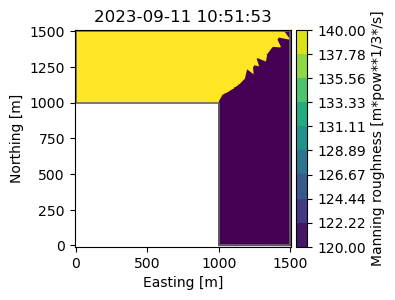

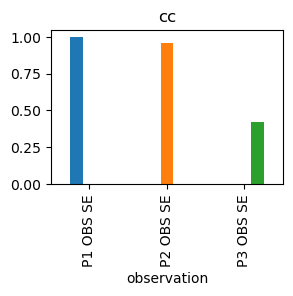

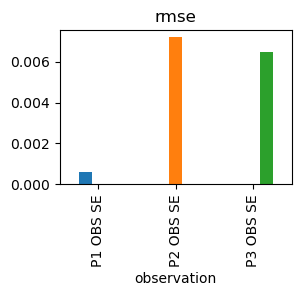

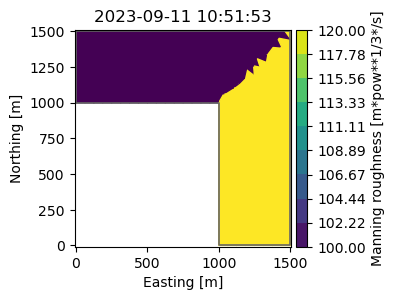

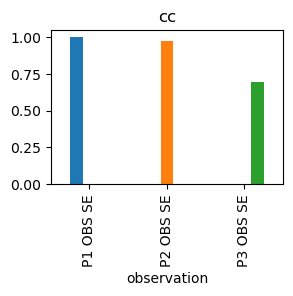

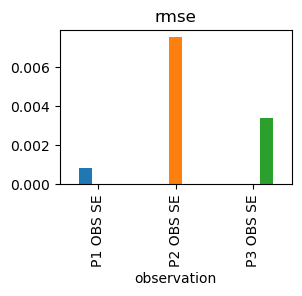

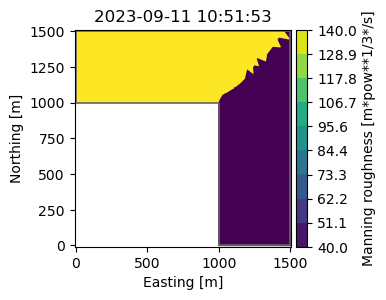

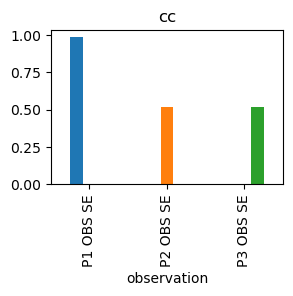

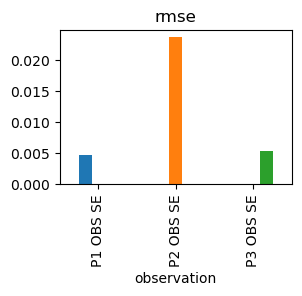

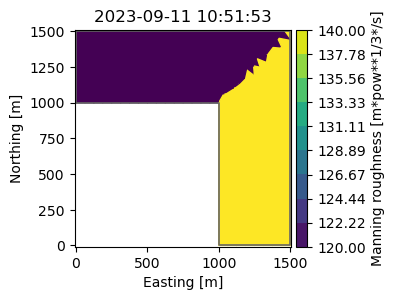

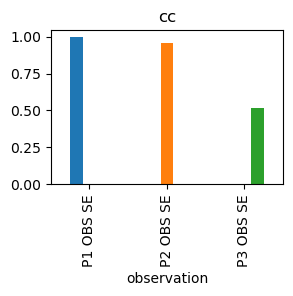

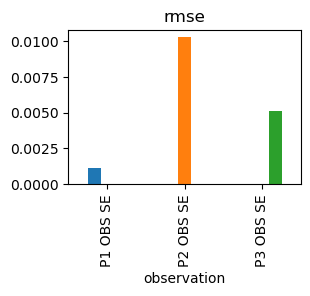

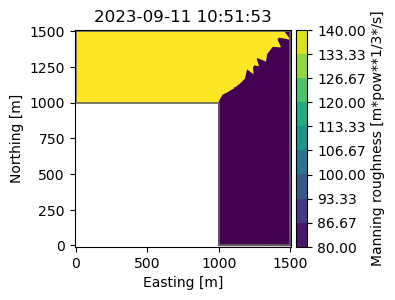

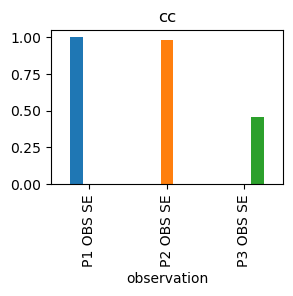

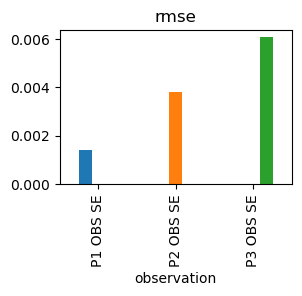

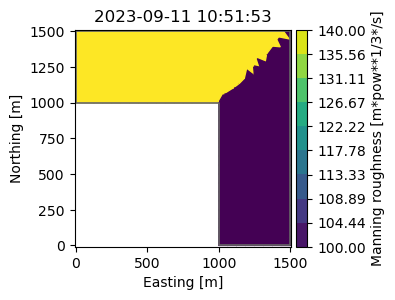

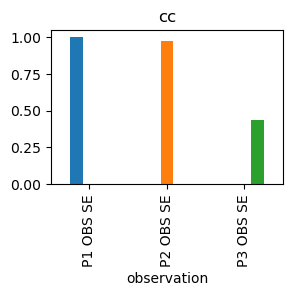

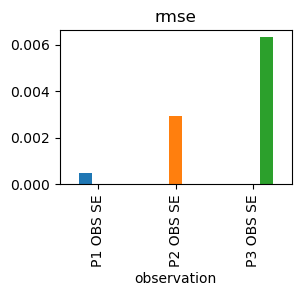

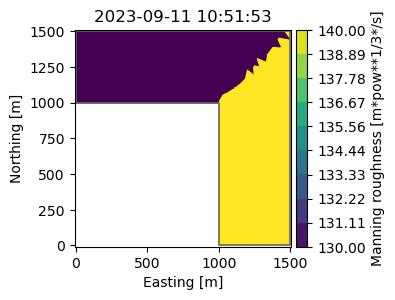

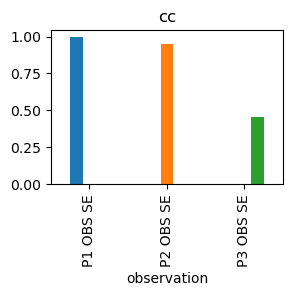

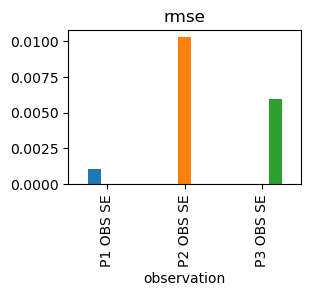

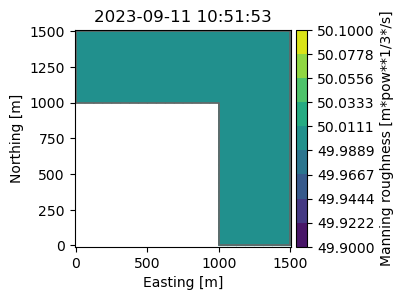

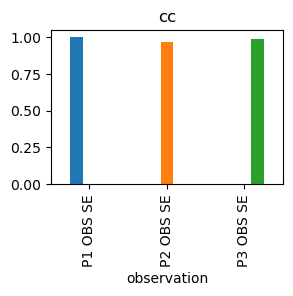

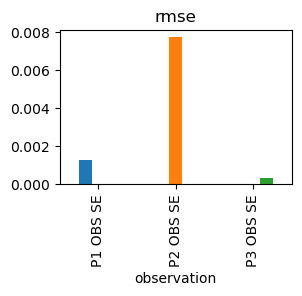

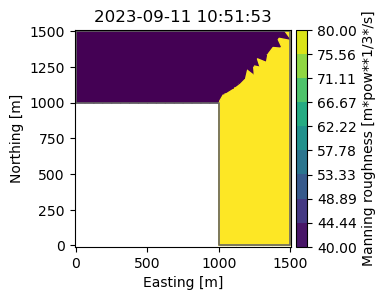

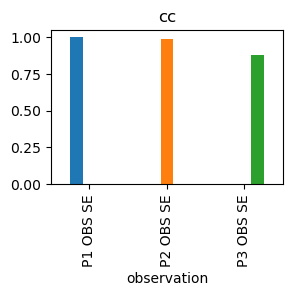

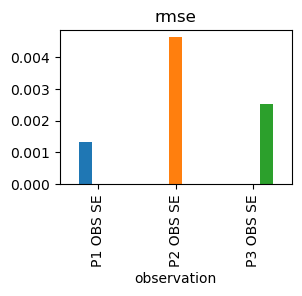

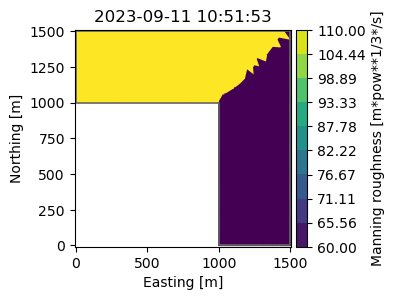

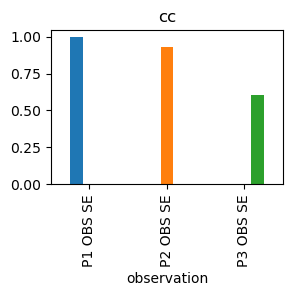

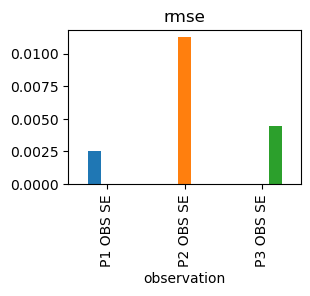

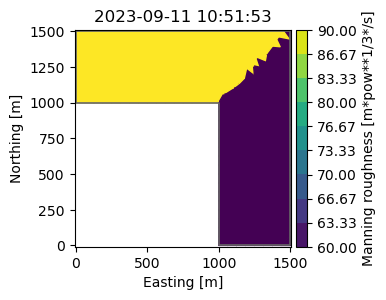

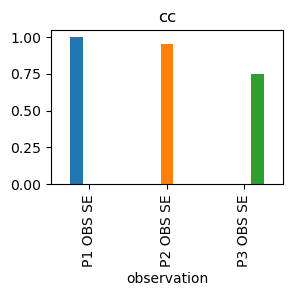

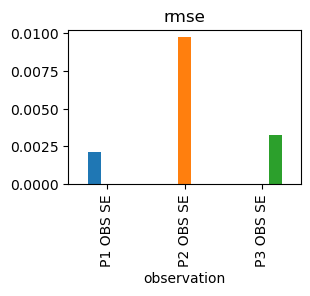

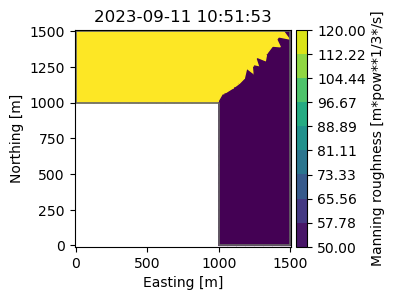

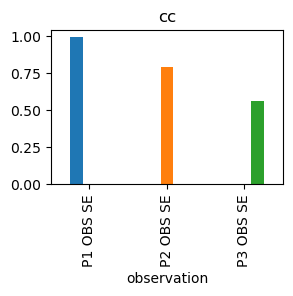

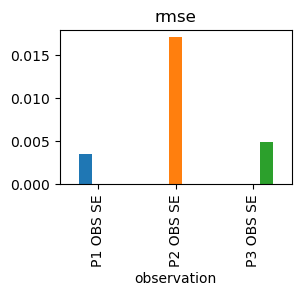

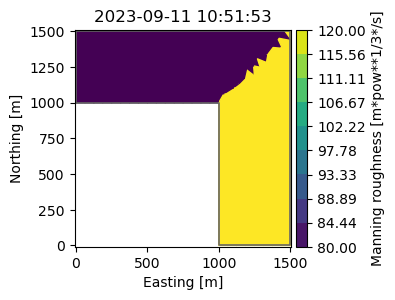

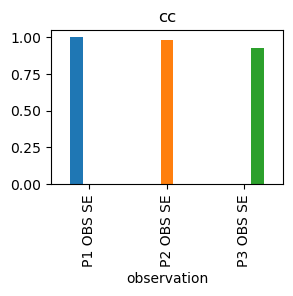

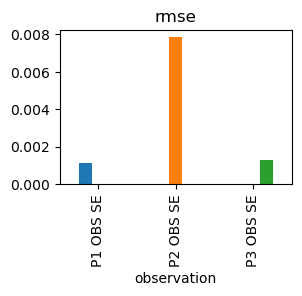

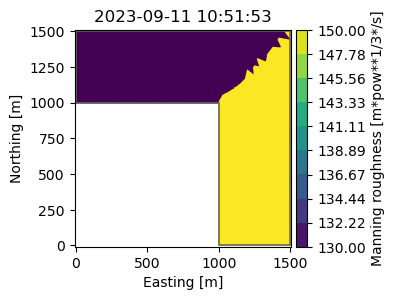

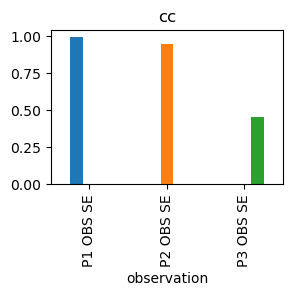

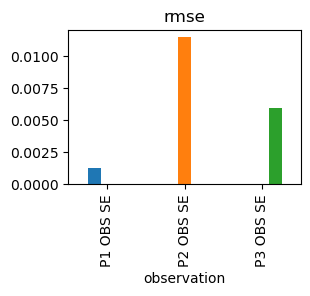

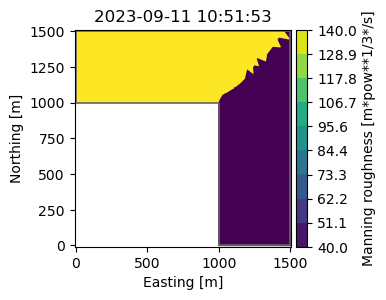

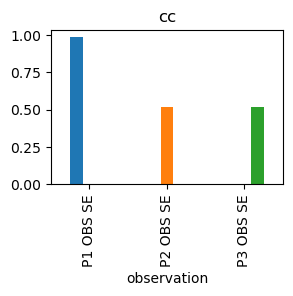

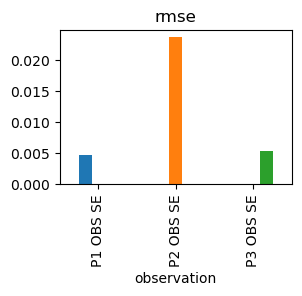

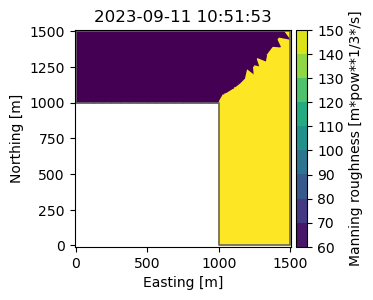

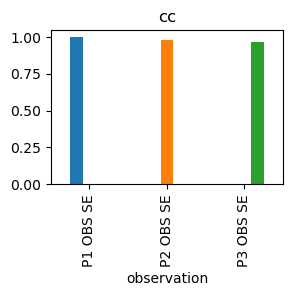

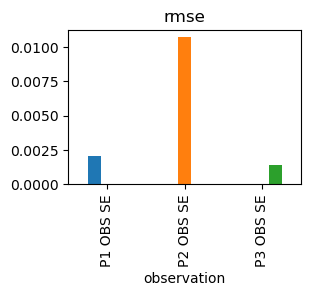

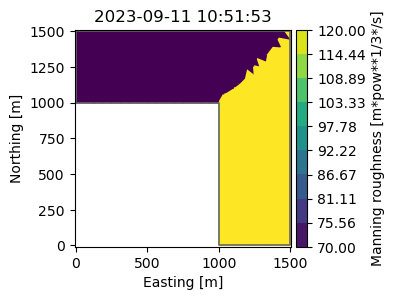

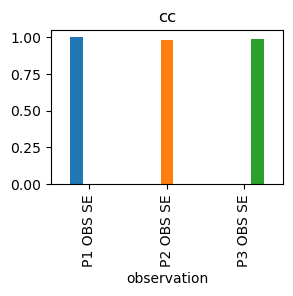

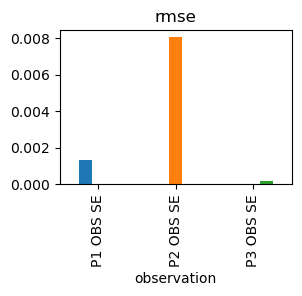

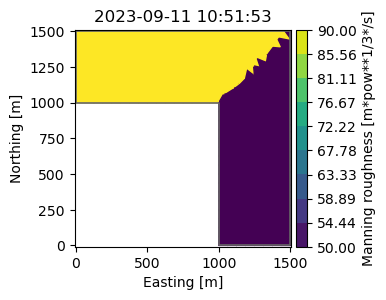

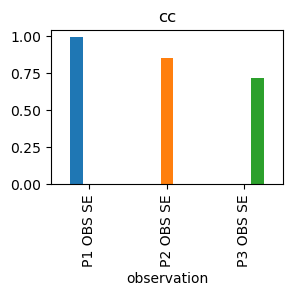

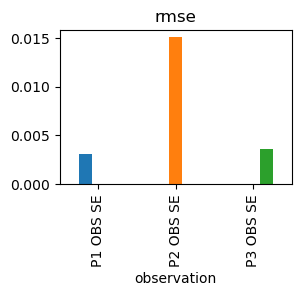

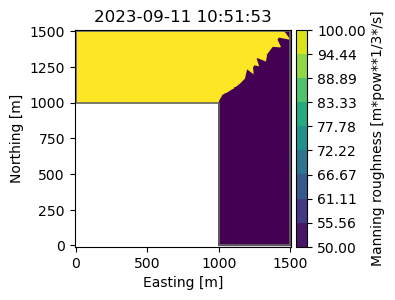

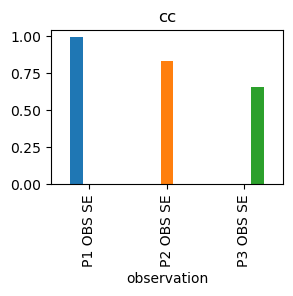

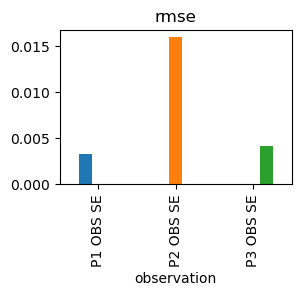

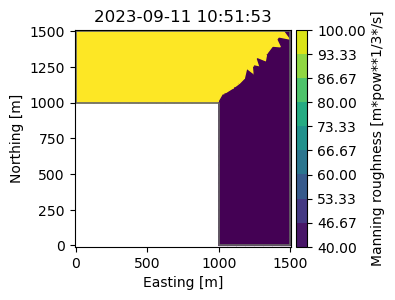

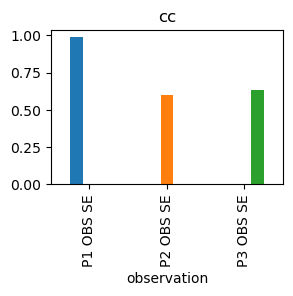

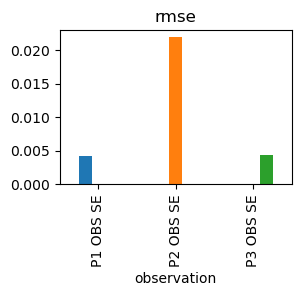

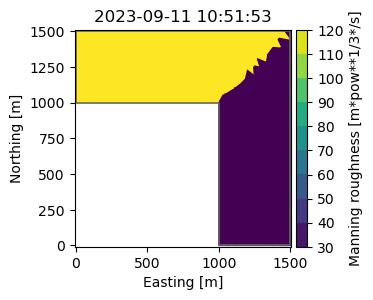

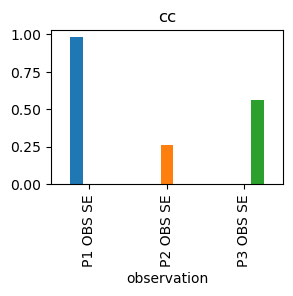

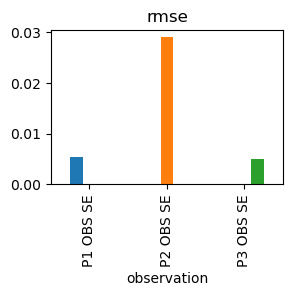

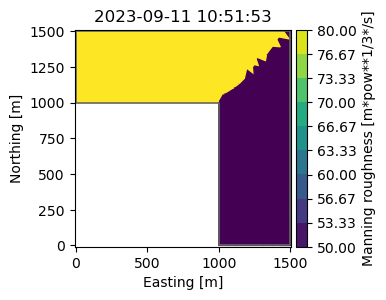

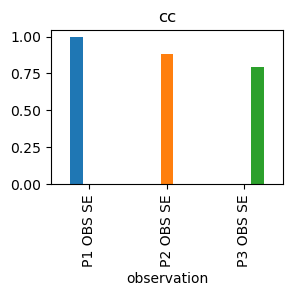

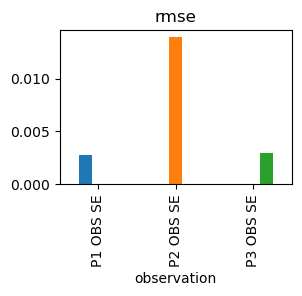

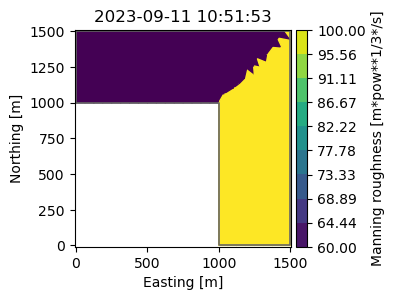

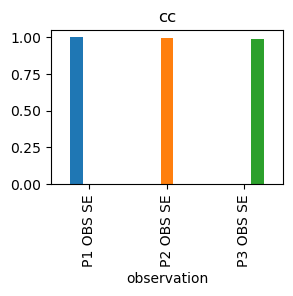

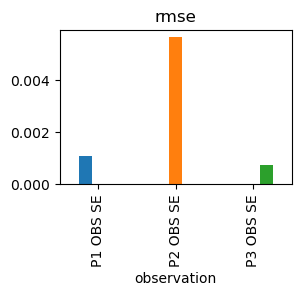

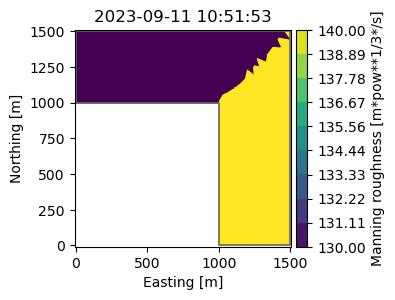

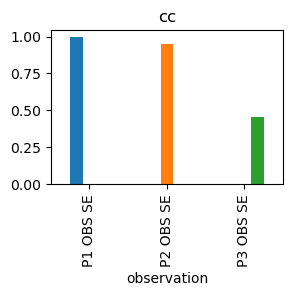

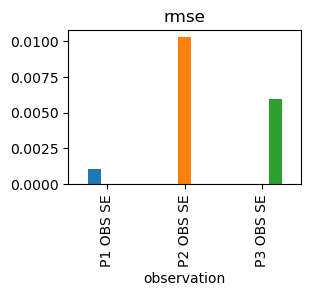

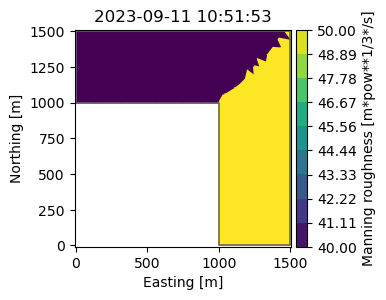

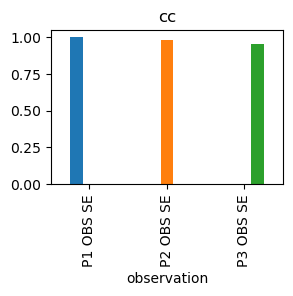

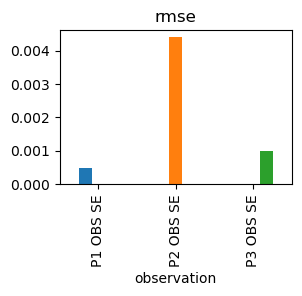

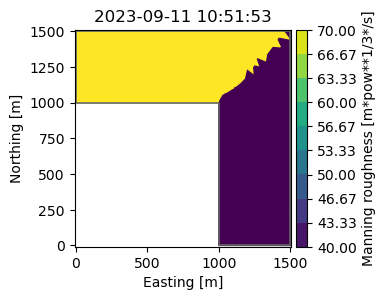

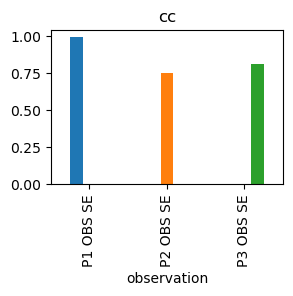

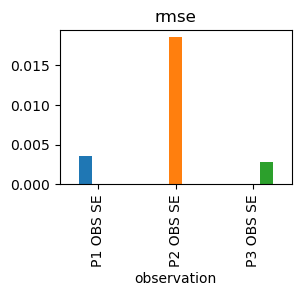

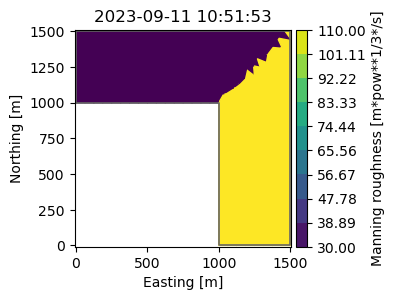

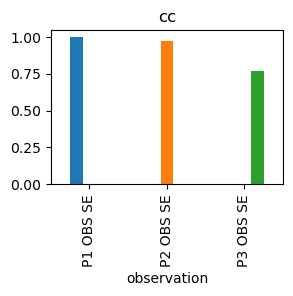

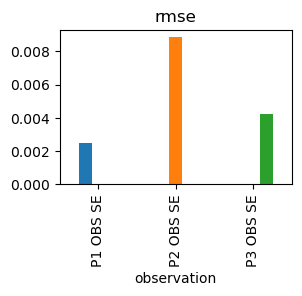

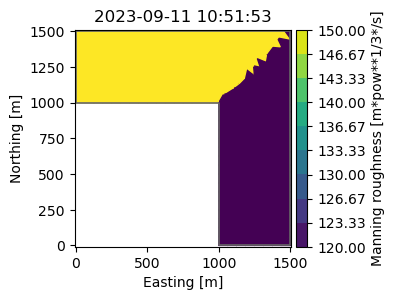

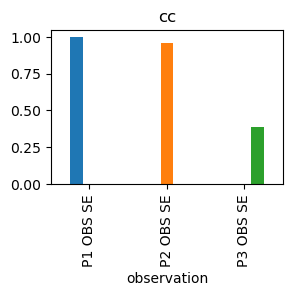

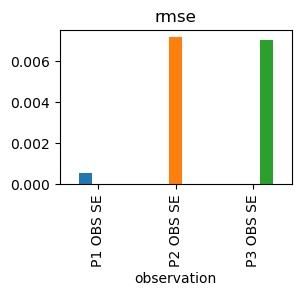

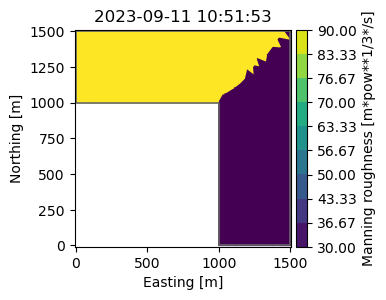

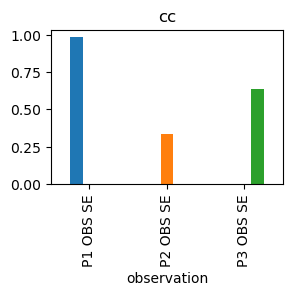

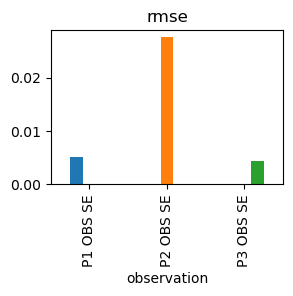

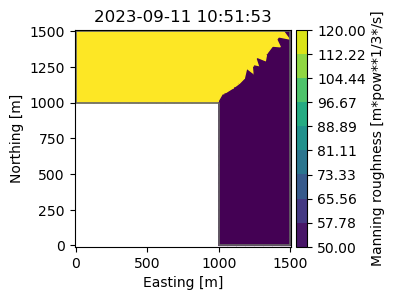

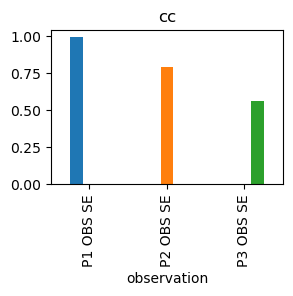

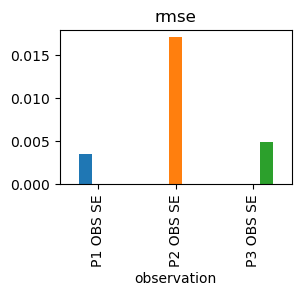

In [4]:
# ----------------------------------------------------
# optimize objective function and running simulations
# ----------------------------------------------------
study.optimize(objective, 
               n_trials=30, 
               timeout=None, 
               #gc_after_trial=True, # doesn't work in this instance and comes with a performance tradeoff
               n_jobs=1, # number of jobs in parallel (if set to -1 automatically adapts to cpu count)
               ) 

## evaluate optimization

In [5]:
fig = optuna.visualization.plot_timeline(study)
fig.show()

C:\Users\clcr\AppData\Local\Temp\ipykernel_13784\2903521836.py:1: ExperimentalWarning: plot_timeline is experimental (supported from v3.2.0). The interface can change in the future.
  fig = optuna.visualization.plot_timeline(study)


In [6]:
study.trials_dataframe()

,number,values_cc,values_rmse,datetime_start,datetime_complete,duration,params_roughness_1,params_roughness_2,system_attrs_nsga2:generation,state
0,0,0.793028,0.004751,2023-09-12 08:24:32.732228,2023-09-12 08:24:47.131593,0 days 00:00:14.399365,140,120,0,COMPLETE
1,1,0.888219,0.003900,2023-09-12 08:24:47.139851,2023-09-12 08:25:13.122089,0 days 00:00:25.982238,100,120,0,COMPLETE
2,2,0.673886,0.011198,2023-09-12 08:25:13.138313,2023-09-12 08:25:41.368833,0 days 00:00:28.230520,140,40,0,COMPLETE
3,3,0.822230,0.005513,2023-09-12 08:25:41.433982,2023-09-12 08:26:11.988693,0 days 00:00:30.554711,120,140,0,COMPLETE
4,4,0.811408,0.003754,2023-09-12 08:26:12.014122,2023-09-12 08:26:48.649154,0 days 00:00:36.635032,140,80,0,COMPLETE
5,5,0.802757,0.003239,2023-09-12 08:26:48.714301,2023-09-12 08:27:37.526970,0 days 00:00:48.812669,140,100,0,COMPLETE
6,6,0.801244,0.005763,2023-09-12 08:27:37.590844,2023-09-12 08:28:22.831071,0 days 00:00:45.240227,130,140,0,COMPLETE
7,7,0.986279,0.003112,2023-09-12 08:28:22.878417,2023-09-12 08:28:59.937294,0 days 00:00:37.058877,50,50,0,COMPLETE
8,8,0.956660,0.002827,2023-09-12 08:29:00.071503,2023-09-12 08:29:40.822724,0 days 00:00:40.751221,40,80,0,COMPLETE
9,9,0.843693,0.006077,2023-09-12 08:29:40.858697,2023-09-12 08:30:34.343144,0 days 00:00:53.484447,110,60,0,COMPLETE


In [7]:
fig = optuna.visualization.plot_pareto_front(study, target_names=["RMSE", "CC"])
fig.show()

In [8]:
# for first objective RMSE
fig = optuna.visualization.plot_param_importances(study, target=lambda t: t.values[0])
fig.show()

c:\Users\clcr\AppData\Local\mambaforge\envs\autocalibration\Lib\site-packages\optuna\visualization\_utils.py:67: UserWarning:

`target` is specified, but `target_name` is the default value, 'Objective Value'.



# Evaluate best model in more detail

use modelskill to plot scatter diagrams and timeseries of best model vs. observation

In [20]:
sim_fold

WindowsPath('C:/Source/autocalibration/data/Example_Corner')

In [24]:
trial_number = 24 # choose best or any trial number to evaluate

print("parameters: ", study.trials[trial_number].params)
print("RMSE, CC:", study.trials[trial_number].values)

# ----------------------------------------------------
# read best simulation results
# ----------------------------------------------------
# reading observations (paths here remain the same)
obs_file = "PointsObs.dfs0" # all observations in one file
o1_se = ms.PointObservation(os.path.join(obs_fold,obs_file), 
                            item=0,
                            name='P1 OBS SE')
o2_se = ms.PointObservation(os.path.join(obs_fold,obs_file),
                            item=1,
                            name='P2 OBS SE')
o3_se = ms.PointObservation(os.path.join(obs_fold,obs_file),
                            item=2,
                            name='P3 OBS SE')

# reading simulation results
sim_file = "Points.dfs0"
trial_folder = os.path.join(sim_fold, f"sim_trial_{trial_number}.m21fm - Result Files") # TODO: adjust for other sim names 

mr1_se = ms.ModelResult(os.path.join(trial_folder,sim_file), 
                    item=0, 
                    name="P1 MR SE")
mr2_se = ms.ModelResult(os.path.join(trial_folder,sim_file),
                    item=1,
                    name="P2 MR SE")
mr3_se = ms.ModelResult(os.path.join(trial_folder,sim_file),
                    item=2,
                    name="P3 MR SE")
# adding comparison for each point manually - should be more flexible later
c1 = ms.compare(o1_se, mr1_se)
c2 = ms.compare(o2_se, mr2_se)
c3 = ms.compare(o3_se, mr3_se)
cc = c1 + c2 + c3

s = cc.skill(metrics=['rmse', 'cc'])
s.round(3)


parameters:  {'roughness_1': 40, 'roughness_2': 50}
RMSE, CC: [0.001959277019504327, 0.9771018461196039]


,,n,rmse,cc
model,observation,,,
Point 1: Surface elevation,P1 OBS SE,721,0.000,0.999
Point 2: Surface elevation,P2 OBS SE,721,0.004,0.981
Point 3: Surface elevation,P3 OBS SE,721,0.001,0.952


<Axes: title={'center': 'rmse'}, xlabel='observation'>

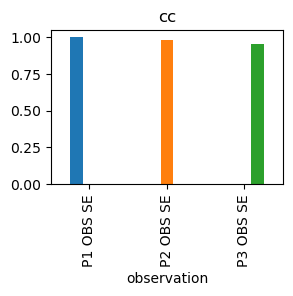

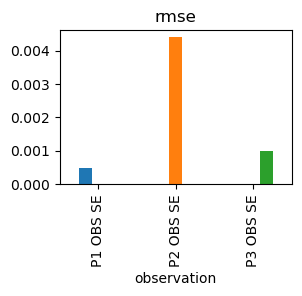

In [25]:
# do plots
s.plot_bar(field='cc', figsize=(3,2), legend=False)
s.plot_bar(field='rmse', figsize=(3,2), legend=False)   